In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
id_cols = ['Client', 'Warehouse', 'Product']

In [3]:
# Read price data
price_p0 = pd.read_csv("../data/Phase 0 - Price.csv", na_values=np.nan)
price_p0["Value"] = "Price"
price_p0 = price_p0.set_index(["Client", "Warehouse","Product", "Value"]).stack()

# Read sales data
sales_p0 = pd.read_csv("../data/Phase 0 - Sales.csv", na_values=np.nan)
sales_p0["Value"] = "Sales"
sales_p0 = sales_p0.set_index(["Client", "Warehouse","Product", "Value"]).stack()

# Read price validation data
price_p1 = pd.read_csv("../data/Phase 1 - Price.csv", na_values=np.nan)
price_p1["Value"] = "Price"
price_p1 = price_p1.set_index(["Client", "Warehouse","Product", "Value"]).stack()

# Read sales validation data
sales_p1 = pd.read_csv("../data/Phase 1 - Sales.csv", na_values=np.nan)
sales_p1["Value"] = "Sales"
sales_p1 = sales_p1.set_index(["Client", "Warehouse","Product", "Value"]).stack()

# Read sales test data
sales_p2 = pd.read_csv("../data/Phase 2 - Sales.csv", na_values=np.nan)
sales_p2["Value"] = "Sales"
sales_p2 = sales_p2.set_index(["Client", "Warehouse","Product", "Value"]).stack()


In [4]:

# Create single dataframe
df = pd.concat([price_p0, sales_p0]).unstack("Value").reset_index()
df.columns = ["Client", "Warehouse", "Product", "ds", "Price", "y"]
df["ds"] = pd.to_datetime(df["ds"])
df = df.astype({"Price": np.float32,
                "y": np.float32,
                "Client": "category",
                "Warehouse": "category",
                "Product": "category",
                })

df_test = pd.concat([price_p1, sales_p1]).unstack("Value").reset_index()
df_test.columns = ["Client", "Warehouse", "Product", "ds", "Price", "y"]
df_test["ds"] = pd.to_datetime(df_test["ds"])
df_test = df_test.astype({"Price": np.float32,
                "y": np.float32,
                "Client": "category",
                "Warehouse": "category",
                "Product": "category",
                })

In [5]:
train_df = pd.concat([df, df_test])
train_df.reset_index(drop = True, inplace= True)

In [6]:
sales_p2 = sales_p2.unstack("Value").reset_index()
sales_p2.columns = ["Client", "Warehouse", "Product", "ds", "y"]
sales_p2['ds'] = pd.to_datetime(sales_p2['ds'])

In [11]:
train_df[(train_df['Product'] == 367) & (train_df['ds'] == '2020-07-06')]

,Client,Warehouse,Product,ds,Price,y
0,0,1,367,2020-07-06,10.900001,7.0
28560,0,47,367,2020-07-06,5.350000,7.0
39950,0,83,367,2020-07-06,21.885000,14.0
47090,0,95,367,2020-07-06,NaN,0.0
52700,0,100,367,2020-07-06,3.290000,7.0
58310,0,120,367,2020-07-06,1.710000,7.0
65450,0,121,367,2020-07-06,48.970001,189.0
75820,0,123,367,2020-07-06,9.030000,7.0
82110,0,154,367,2020-07-06,NaN,0.0
88740,0,155,367,2020-07-06,NaN,0.0


In [38]:
train_df_agg = train_df.groupby(['Client', 'ds'], observed=True).agg({'Price': 'mean', 'y': 'sum'})
train_df_agg = train_df_agg.reset_index()

In [39]:
sales_p2_agg = sales_p2.groupby(['Client', 'ds'], observed=True).agg({'y': 'sum'})
sales_p2_agg = sales_p2_agg.reset_index()

In [40]:
combinations = train_df_agg[['Client']].drop_duplicates()
combinations.shape
combinations = combinations.merge(pd.DataFrame({'ds': sales_p2_agg['ds'].unique()}), how='cross')
combinations['Price'] = np.nan
combinations['y'] = np.nan
combinations['ds']= pd.to_datetime(combinations['ds'])
combinations.shape


(598, 4)

In [41]:
train_df_agg.shape

(8418, 4)

In [44]:
preprocess_df = pd.concat([train_df_agg, combinations])
preprocess_df['ds'] = pd.to_datetime(preprocess_df['ds'])

C:\Users\rucha\AppData\Local\Temp\ipykernel_17988\2538531886.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  preprocess_df = pd.concat([train_df_agg, combinations])


In [51]:
def feature_creation(data):
    id_cols = ['Client']
    data['prev_day']= data['ds'] - pd.Timedelta(days=7)

    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=data['prev_day'].min(), end=data['ds'].max()).to_pydatetime()
    
    data['holiday_count'] = data.apply(
        lambda x: sum(1 for holiday in holidays if holiday.date() >= x['prev_day'].date() and holiday.date() <= x['ds'].date()), axis=1)
    data['is_holiday'] = data['holiday_count'].apply(lambda x: 1 if x > 0 else 0)

    data['is_prev_1week_holidays'] = data.groupby(id_cols, observed=True)['holiday_count'].transform(lambda x: x.shift(1)) 
    data['is_prev_2week_holidays'] = data.groupby(id_cols, observed=True)['holiday_count'].transform(lambda x: x.shift(2)) 

    data["year"] = data["ds"].dt.year
    data["month"] = data["ds"].dt.month
    data["week"] = data["ds"].dt.isocalendar().week
    data["day"] = data["ds"].dt.day
    data["day_of_week"] = data["ds"].dt.weekday
    data["quarter"] = data["ds"].dt.quarter

    for week in range(1, 14+10):
        data.loc[:, f'sales_lag_ph_{week}'] = data.groupby(id_cols, observed=True)['y'].transform(lambda x: x.shift(week))
        data.loc[:, f'price_lag__ph_{week}'] = data.groupby(id_cols, observed=True)['Price'].transform(lambda x: x.shift(week))
    
        for rolling_window in [13,26,39]:
            data.loc[:, f'sales_rolling_mean_ph_{week}_{rolling_window}'] = data.groupby(id_cols, observed=True)['y'].transform(lambda x: x.shift(week).rolling(rolling_window).mean())
            data.loc[:, f'sales_rolling_std_ph_{week}_{rolling_window}'] = data.groupby(id_cols, observed=True)['y'].transform(lambda x: x.shift(week).rolling(rolling_window).std())
            data.loc[:, f'price_rolling_mean_ph_{week}_{rolling_window}'] = data.groupby(id_cols, observed=True)['Price'].transform(lambda x: x.shift(week).rolling(rolling_window).mean())
            data.loc[:, f'price_rolling_std_ph_{week}_{rolling_window}'] = data.groupby(id_cols, observed=True)['Price'].transform(lambda x: x.shift(week).rolling(rolling_window).std())

    data = data.drop(columns = ['prev_day'])
    return data    


In [52]:
preprocess_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9016 entries, 0 to 597
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Client                  9016 non-null   category      
 1   ds                      9016 non-null   datetime64[ns]
 2   Price                   6906 non-null   float32       
 3   y                       8418 non-null   float32       
 4   prev_day                9016 non-null   datetime64[ns]
 5   holiday_count           9016 non-null   int64         
 6   is_holiday              9016 non-null   int64         
 7   is_prev_1week_holidays  8970 non-null   float64       
 8   is_prev_2week_holidays  8924 non-null   float64       
 9   year                    9016 non-null   int32         
 10  month                   9016 non-null   int32         
 11  week                    9016 non-null   UInt32        
 12  day                     9016 non-null   int32         

In [53]:
data = feature_creation(preprocess_df)

C:\Users\rucha\AppData\Local\Temp\ipykernel_17988\160344262.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'sales_rolling_std_ph_{week}_{rolling_window}'] = data.groupby(id_cols, observed=True)['y'].transform(lambda x: x.shift(week).rolling(rolling_window).std())
C:\Users\rucha\AppData\Local\Temp\ipykernel_17988\160344262.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'price_rolling_mean_ph_{week}_{rolling_window}'] = data.groupby(id_cols, observed=True)['Price'].transform(lambda x: x.shift(

In [59]:
train_df = data[~data['ds'].isin(sales_p2_agg['ds'].unique())]
test_df = data[data['ds'].isin(sales_p2_agg['ds'].unique())]

train_df.to_csv("../data/agg_preprocessed_train_df.csv", index = False)
test_df.to_csv("../data/agg_preprocessed_test_df.csv", index = False)

In [60]:
del data, preprocess_df, sales_p2_agg, price_p0, price_p1, sales_p0, sales_p1, sales_p2

In [142]:
train_df.shape

(8418, 336)

In [143]:
test_df.shape

(598, 336)

In [144]:
import lightgbm as lgb
from sklearn import metrics
import joblib
id_cols = ['Client']

In [145]:
#TODO in fine tuning
params = {'num_leaves': 555,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 31,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
         }

In [148]:
test_df['ds'].unique()

<DatetimeArray>
['2024-01-08 00:00:00', '2024-01-15 00:00:00', '2024-01-22 00:00:00',
 '2024-01-29 00:00:00', '2024-02-05 00:00:00', '2024-02-12 00:00:00',
 '2024-02-19 00:00:00', '2024-02-26 00:00:00', '2024-03-04 00:00:00',
 '2024-03-11 00:00:00', '2024-03-18 00:00:00', '2024-03-25 00:00:00',
 '2024-04-01 00:00:00']
Length: 13, dtype: datetime64[ns]

In [149]:
### for forecast_horizon create separate dataframes for training and prediction
columns = ['holiday_count', 'is_holiday', 'is_prev_1week_holidays', 'is_prev_2week_holidays',
           'year', 'month', 'week', 'day', 'day_of_week', 'quarter']

predictions = []
rolling_windows = [13, 26, 39]  # Automate 13, 26, 39 dynamically


for horizon, date in enumerate(test_df['ds'].unique()):
    horizon += 1
    # Generate feature names dynamically
    horizon_specific_cols =  [f'price_lag__ph_{i}' for i in range(horizon, 14+10)] +  \
        [f'price_rolling_mean_ph_{i}_{w}' for i in range(horizon, 14+10) for w in rolling_windows] +\
        [f'price_rolling_std_ph_{i}_{w}' for i in range(horizon, 14+10) for w in rolling_windows] +\
        [f'sales_rolling_std_ph_{i}_{w}' for i in range(horizon, 14+10) for w in rolling_windows] +\
        [f'sales_rolling_mean_ph_{i}_{w}' for i in range(horizon, 14+10) for w in rolling_windows]  
    
    all_feature_cols = id_cols+columns+horizon_specific_cols

    x_train = train_df[all_feature_cols].copy()
    y_train = train_df['y'].copy()
    
    dtrain = lgb.Dataset(x_train, label=y_train)
    
    x_pred = test_df[test_df['ds']==date][all_feature_cols].copy()

    pred_combo = test_df[test_df['ds']==date][id_cols+['ds']]

    clf = lgb.train(params, dtrain, 2500)

    joblib.dump(clf, f"../model/vn1_horizon_{horizon}.pkl")

    pred_combo['prediction'] = clf.predict(x_pred)
    predictions.append(pred_combo)

    del x_train, y_train, x_pred
    gc.collect()
    

In [150]:
len(predictions)

13

In [151]:
predictions_df = pd.concat(predictions)

In [152]:
predictions_df = predictions_df.sort_values(['Client', 'ds'])

In [153]:
test_sales = pd.read_csv("../data/actual_sales_p2.csv")

In [154]:
test_sales_agg = test_sales.groupby(['Client', 'ds'], observed=True).agg({'y': 'sum'})
test_sales_agg = test_sales_agg.reset_index()

In [155]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 598 entries, 0 to 597
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Client      598 non-null    category      
 1   ds          598 non-null    datetime64[ns]
 2   prediction  598 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 16.0 KB


In [156]:
test_sales_agg['ds'] = pd.to_datetime(test_sales_agg['ds'])

In [157]:
predictions_df.head()

,Client,ds,prediction
0,0,2024-01-08,39793.084747
1,0,2024-01-15,41743.004385
2,0,2024-01-22,42353.090121
3,0,2024-01-29,41905.457081
4,0,2024-02-05,44610.881096


In [158]:
output = test_sales_agg.merge(predictions_df, on = ['Client', 'ds'])

In [159]:
from eval import custom_error

In [160]:
custom_error(output['y'], output['prediction'])

0.3460485495500209

In [161]:
test_df.shape

(598, 336)

In [162]:
predictions_df.shape

(598, 3)

In [163]:
predictions_df

,Client,ds,prediction
0,0,2024-01-08,39793.084747
1,0,2024-01-15,41743.004385
2,0,2024-01-22,42353.090121
3,0,2024-01-29,41905.457081
4,0,2024-02-05,44610.881096
...,...,...,...
593,46,2024-03-04,2954.995267
594,46,2024-03-11,3048.352207
595,46,2024-03-18,3107.870803
596,46,2024-03-25,3595.834349


In [165]:
test_sales_agg

,Client,ds,y
0,0,2024-01-08,39807.0
1,0,2024-01-15,38851.0
2,0,2024-01-22,44560.0
3,0,2024-01-29,45587.0
4,0,2024-02-05,31395.0
...,...,...,...
593,46,2024-03-04,3476.0
594,46,2024-03-11,3193.0
595,46,2024-03-18,3140.0
596,46,2024-03-25,3270.0


In [174]:
output.to_csv("../output/client_level_agg_output.csv", index = False)

In [175]:
output['Client'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=object)

C:\Users\rucha\AppData\Local\Temp\ipykernel_17988\2936289682.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out1.sort_values(by = 'ds', inplace=True)


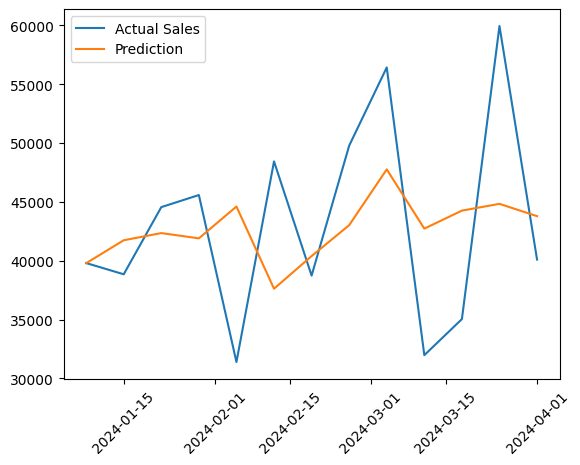

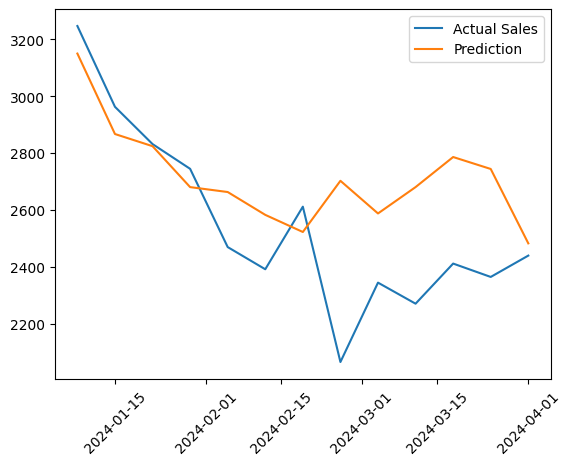

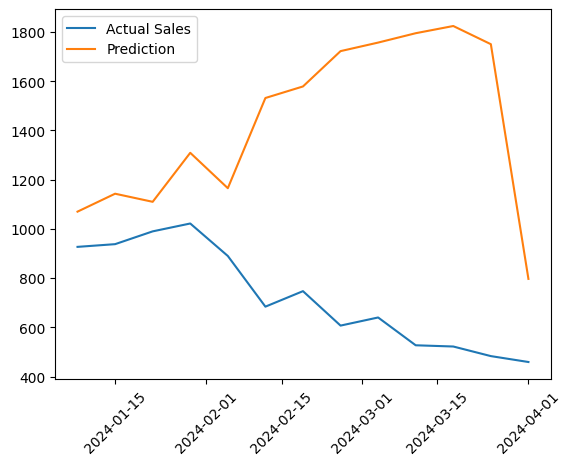

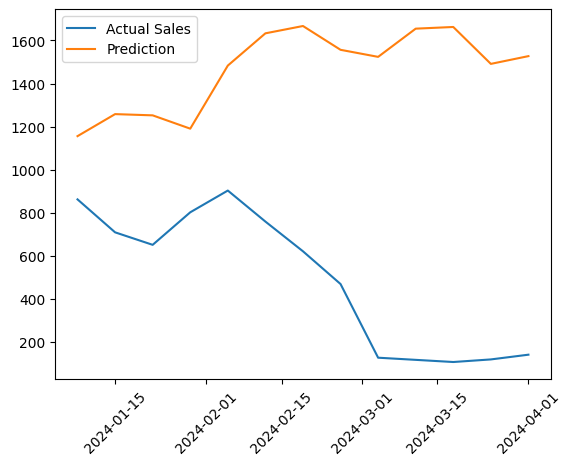

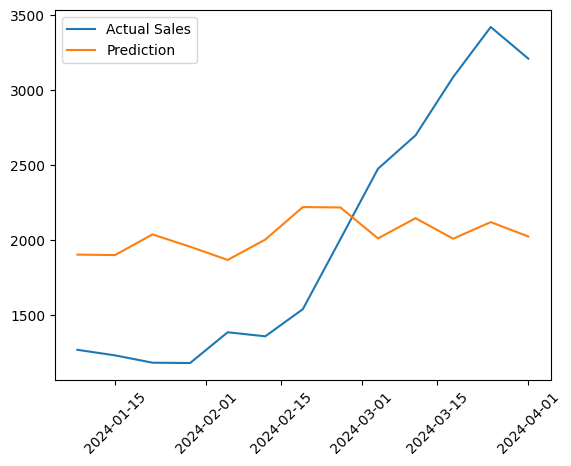

In [176]:
client = 0

import matplotlib.pyplot as plt

for client in [0, 10, 20, 30, 40]:
    out1 = output[output['Client'] == client]
    out1.sort_values(by = 'ds', inplace=True)
    out1.set_index('ds', inplace=True)
    plt.plot(out1['y'])
    plt.plot(out1['prediction'])
    plt.legend(['Actual Sales', 'Prediction'])
    plt.xticks(rotation = 45)
    plt.show();
